### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
8,NSW9,1,22,16,1,0,0,0,0.0000,0.0000,2164.022
448,PSID264,0,17,8,0,1,0,1,391.8534,300.7742,18891.260
344,PSID160,0,25,14,0,1,1,0,1622.2730,2239.6940,1892.968
217,PSID33,0,27,12,0,0,1,0,12270.8900,7709.1290,7806.829
554,PSID370,0,16,9,1,0,0,1,0.0000,0.0000,2158.959
124,NSW125,1,18,11,0,0,0,1,3678.2310,919.5579,4321.705
546,PSID362,0,26,12,0,1,1,0,47.0224,0.0000,0.000
211,PSID27,0,36,9,1,0,1,1,13256.4000,8457.4840,0.000
263,PSID79,0,23,17,0,0,0,0,0.0000,4876.8390,16747.080
247,PSID63,0,31,2,0,1,1,1,3262.1790,5965.3550,9732.307


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

In [3]:
''' your code and explanations '''
treated = df.loc[df.treat ==1]
control = df.loc[df.treat ==0]

In [4]:
treated.re78.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [5]:
control.re78.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

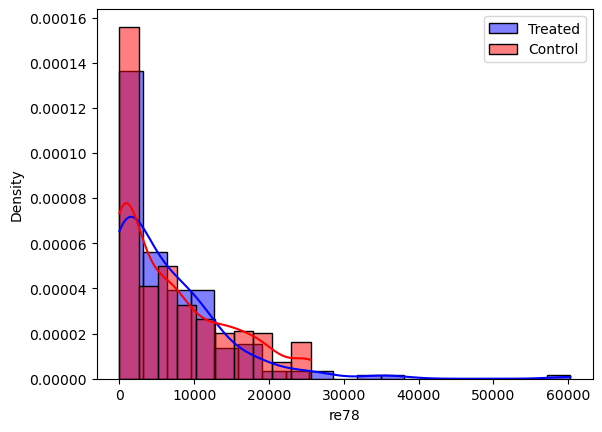

In [6]:
ax = sns.histplot(treated.re78, color ='blue', label = 'Treated', stat = 'density', kde = True, alpha = 0.5)
ax = sns.histplot(control.re78, color = 'red', label = 'Control', stat = 'density', kde = True, alpha = 0.5)
plt.legend()
plt.show()

C:\Users\bapti\AppData\Local\Temp\ipykernel_19228\1731742090.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data = df, x='treat', y = 're78', palette = ['red','blue'])


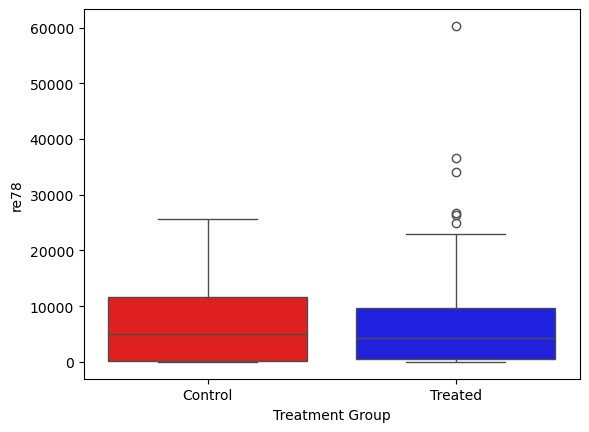

In [7]:
ax = sns.boxplot(data = df, x='treat', y = 're78', palette = ['red','blue'])
plt.xticks([0, 1], ['Control', 'Treated'])
plt.xlabel('Treatment Group')
plt.ylabel('re78')
plt.show()

We can see that : 
- For the treated group
  1. lower mean value
  2. higher first 75%
  3. Some enormous outliers above 27 000 income
- For the control group
  1. higher mean value
  2. higher 50% and 75%
  3. higher density of people between 12 000 and 27 000 income
  

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

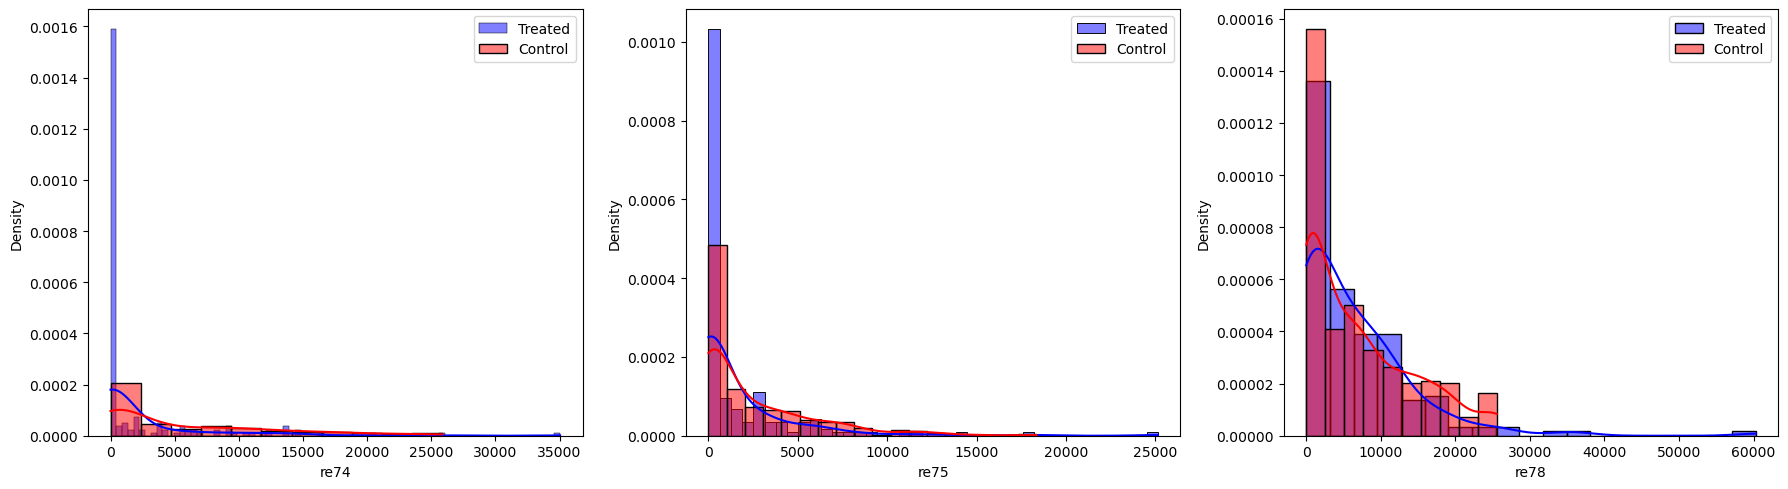

In [8]:
''' your code and explanations '''

fig, (ax1, ax2, ax3)= plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(treated.re74, color ='blue', label = 'Treated', stat = 'density', kde = True, alpha = 0.5, ax = ax1)
sns.histplot(control.re74, color = 'red', label = 'Control', stat = 'density', kde = True, alpha = 0.5, ax = ax1)
ax1.set_xlabel('re74')
ax1.set_ylabel('Density')
ax1.legend()

sns.histplot(treated.re75, color ='blue', label = 'Treated', stat = 'density', kde = True, alpha = 0.5, ax = ax2)
sns.histplot(control.re75, color = 'red', label = 'Control', stat = 'density', kde = True, alpha = 0.5, ax = ax2)
ax2.set_xlabel('re75')
ax2.set_ylabel('Density')
ax2.legend()

sns.histplot(treated.re78, color ='blue', label = 'Treated', stat = 'density', kde = True, alpha = 0.5, ax = ax3)
sns.histplot(control.re78, color = 'red', label = 'Control', stat = 'density', kde = True, alpha = 0.5, ax = ax3)
ax3.set_xlabel('re78')
ax3.set_ylabel('Density')
ax3.legend()

plt.tight_layout()
plt.show()

In [9]:
#on observe que le nombre de personne sans emploi avant le traitemet est énorme ! (pic bleu en 0) 
# le traitement a permis aux gens de trouver un emploi 

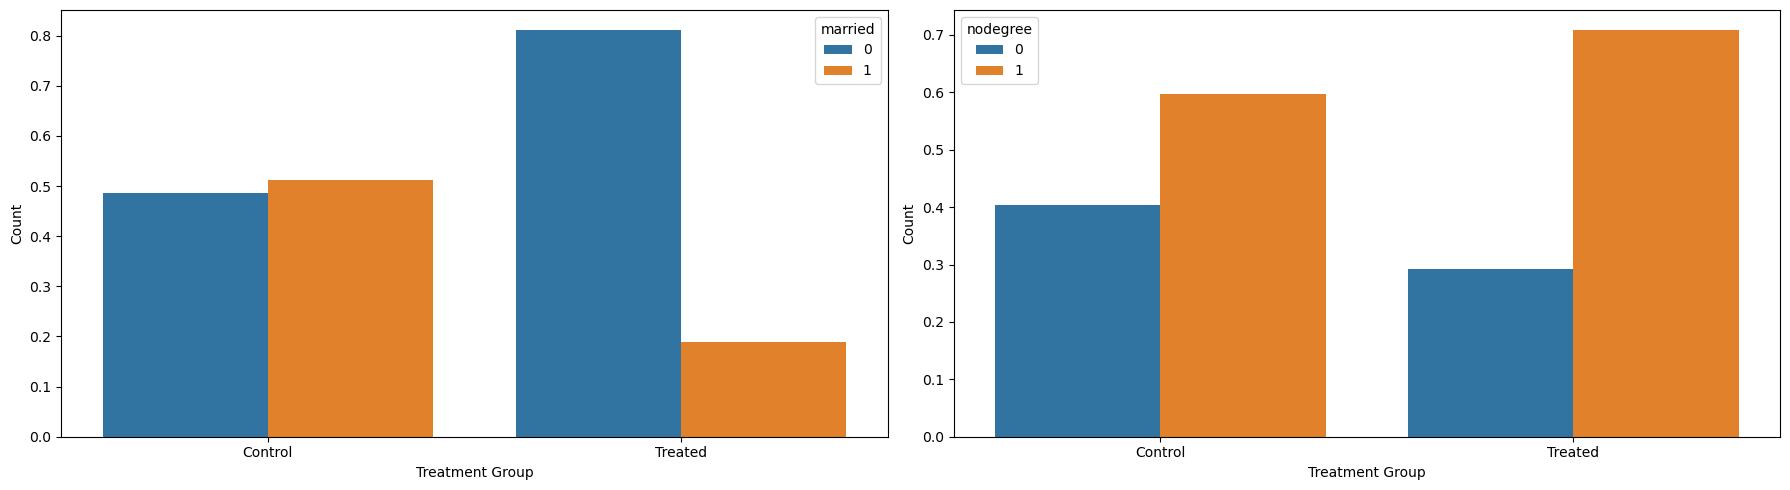

In [10]:
group_married = df.groupby(['treat', 'married'])['married'].count()
group_married = group_married.unstack()
group_married = group_married.div(group_married.sum(axis=1),axis=0) #permet de passer en pourcentage
group_married = group_married.reset_index().melt(id_vars='treat', var_name='married', value_name='count')

group_nodegree = df.groupby(['treat','nodegree'])['nodegree'].count()
group_nodegree = group_nodegree.unstack()
group_nodegree = group_nodegree.div(group_nodegree.sum(axis=1),axis=0) #permet de passer en pourcentage
group_nodegree = group_nodegree.reset_index().melt(id_vars='treat', var_name='nodegree', value_name='count')

#sns.barplot est chiant à utiliser, vaut mieux utiliser df.plot(kind = 'bar', ...)
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(data = group_married, x='treat', y = 'count', hue ='married', ax = axs[0])
axs[0].set_xticks([0, 1], ['Control', 'Treated'])
axs[0].set_xlabel('Treatment Group')
axs[0].set_ylabel('Count')

sns.barplot(data = group_nodegree, x='treat', y = 'count', hue ='nodegree', ax = axs[1])
axs[1].set_xticks([0, 1], ['Control', 'Treated'])
axs[1].set_xlabel('Treatment Group')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [11]:
# on observe que la proportion de marié ou non dans le group control est équivalente
# là ou dans le group treated, les non-mariés sont bien plus présents ! 

# dans le group control, 60% des gens ont un degree
# dans le group treated, c'est 70%, les proportions sont similaires. 

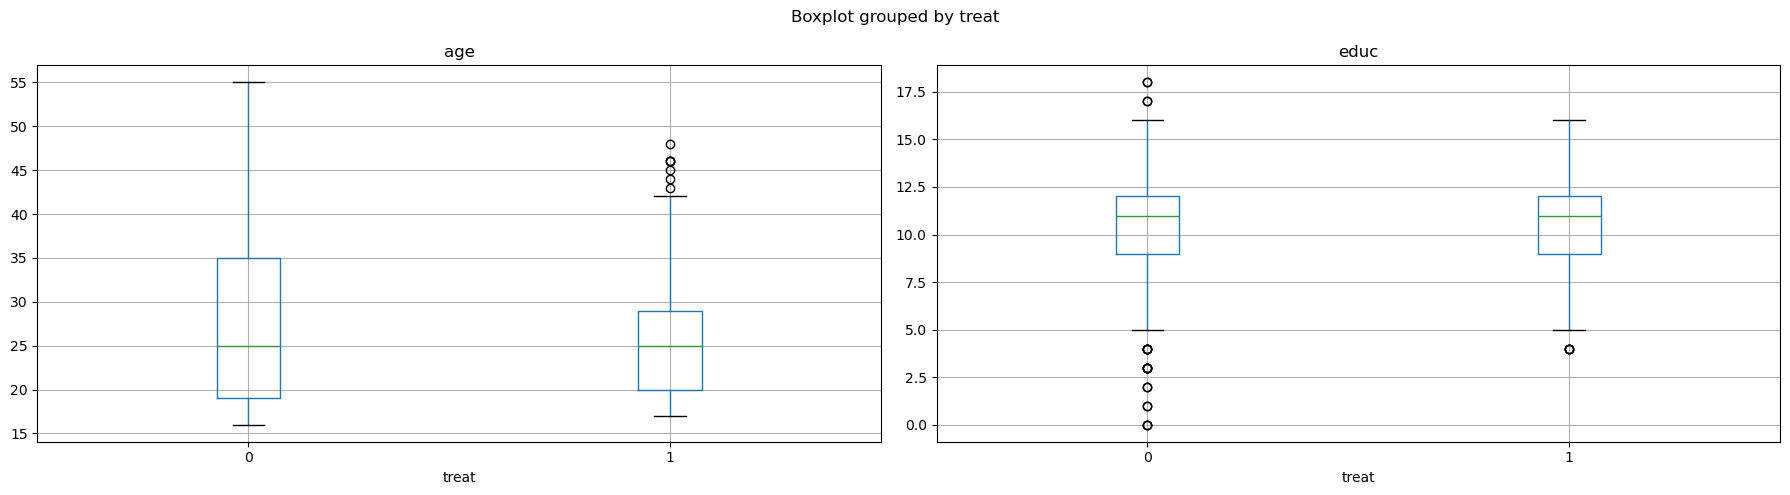

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

df.boxplot(by='treat', column ='age', grid=True, ax = axs[0])
df.boxplot(by='treat', column ='educ', grid=True, ax = axs[1])

plt.tight_layout()
plt.show()

In [13]:
# on observe des moyennes d'ages identiques pour les deux groupes,
# mais une répartition inéquitable. Les membres du groupe treated (1) ont tendance à être plus jeunes.

# on observe qu'au niveau de l'éducation c'est similaire, mais le groupe control (0) a plus d'outliers.

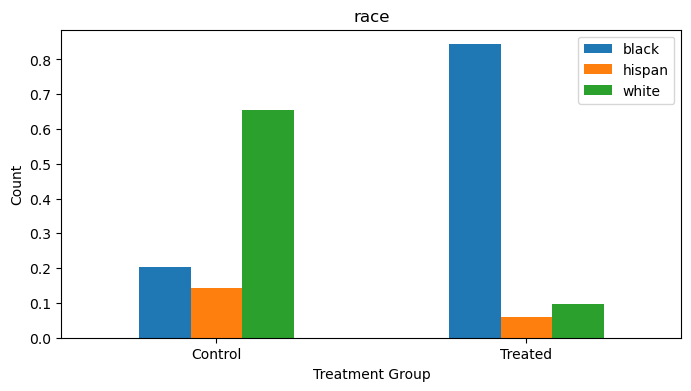

In [14]:
df['white'] = (~(df['black'].astype(bool)|df['hispan'].astype(bool))).astype(bool) #créer une colone pour les blancs

group_ethnic = df.groupby(df.treat)[['black','hispan','white']].sum()
group_ethnic = group_ethnic.div(group_ethnic.sum(axis=1), axis=0)

plot = group_ethnic.plot(kind='bar', figsize=[8,4], rot=0) #, stacked = True)
plot.set_title('race')
plot.set_ylabel('participants')
plot.set_xlabel('group')

plt.xticks([0, 1], ['Control', 'Treated'])
plt.xlabel('Treatment Group')
plt.ylabel('Count')
plt.show()


In [15]:
# on observe une énorme proportion de 'white' dans le groupe control 70% 
# Dans le groupe treated, la proportin de 'black' est beaucoup plus importante 80%

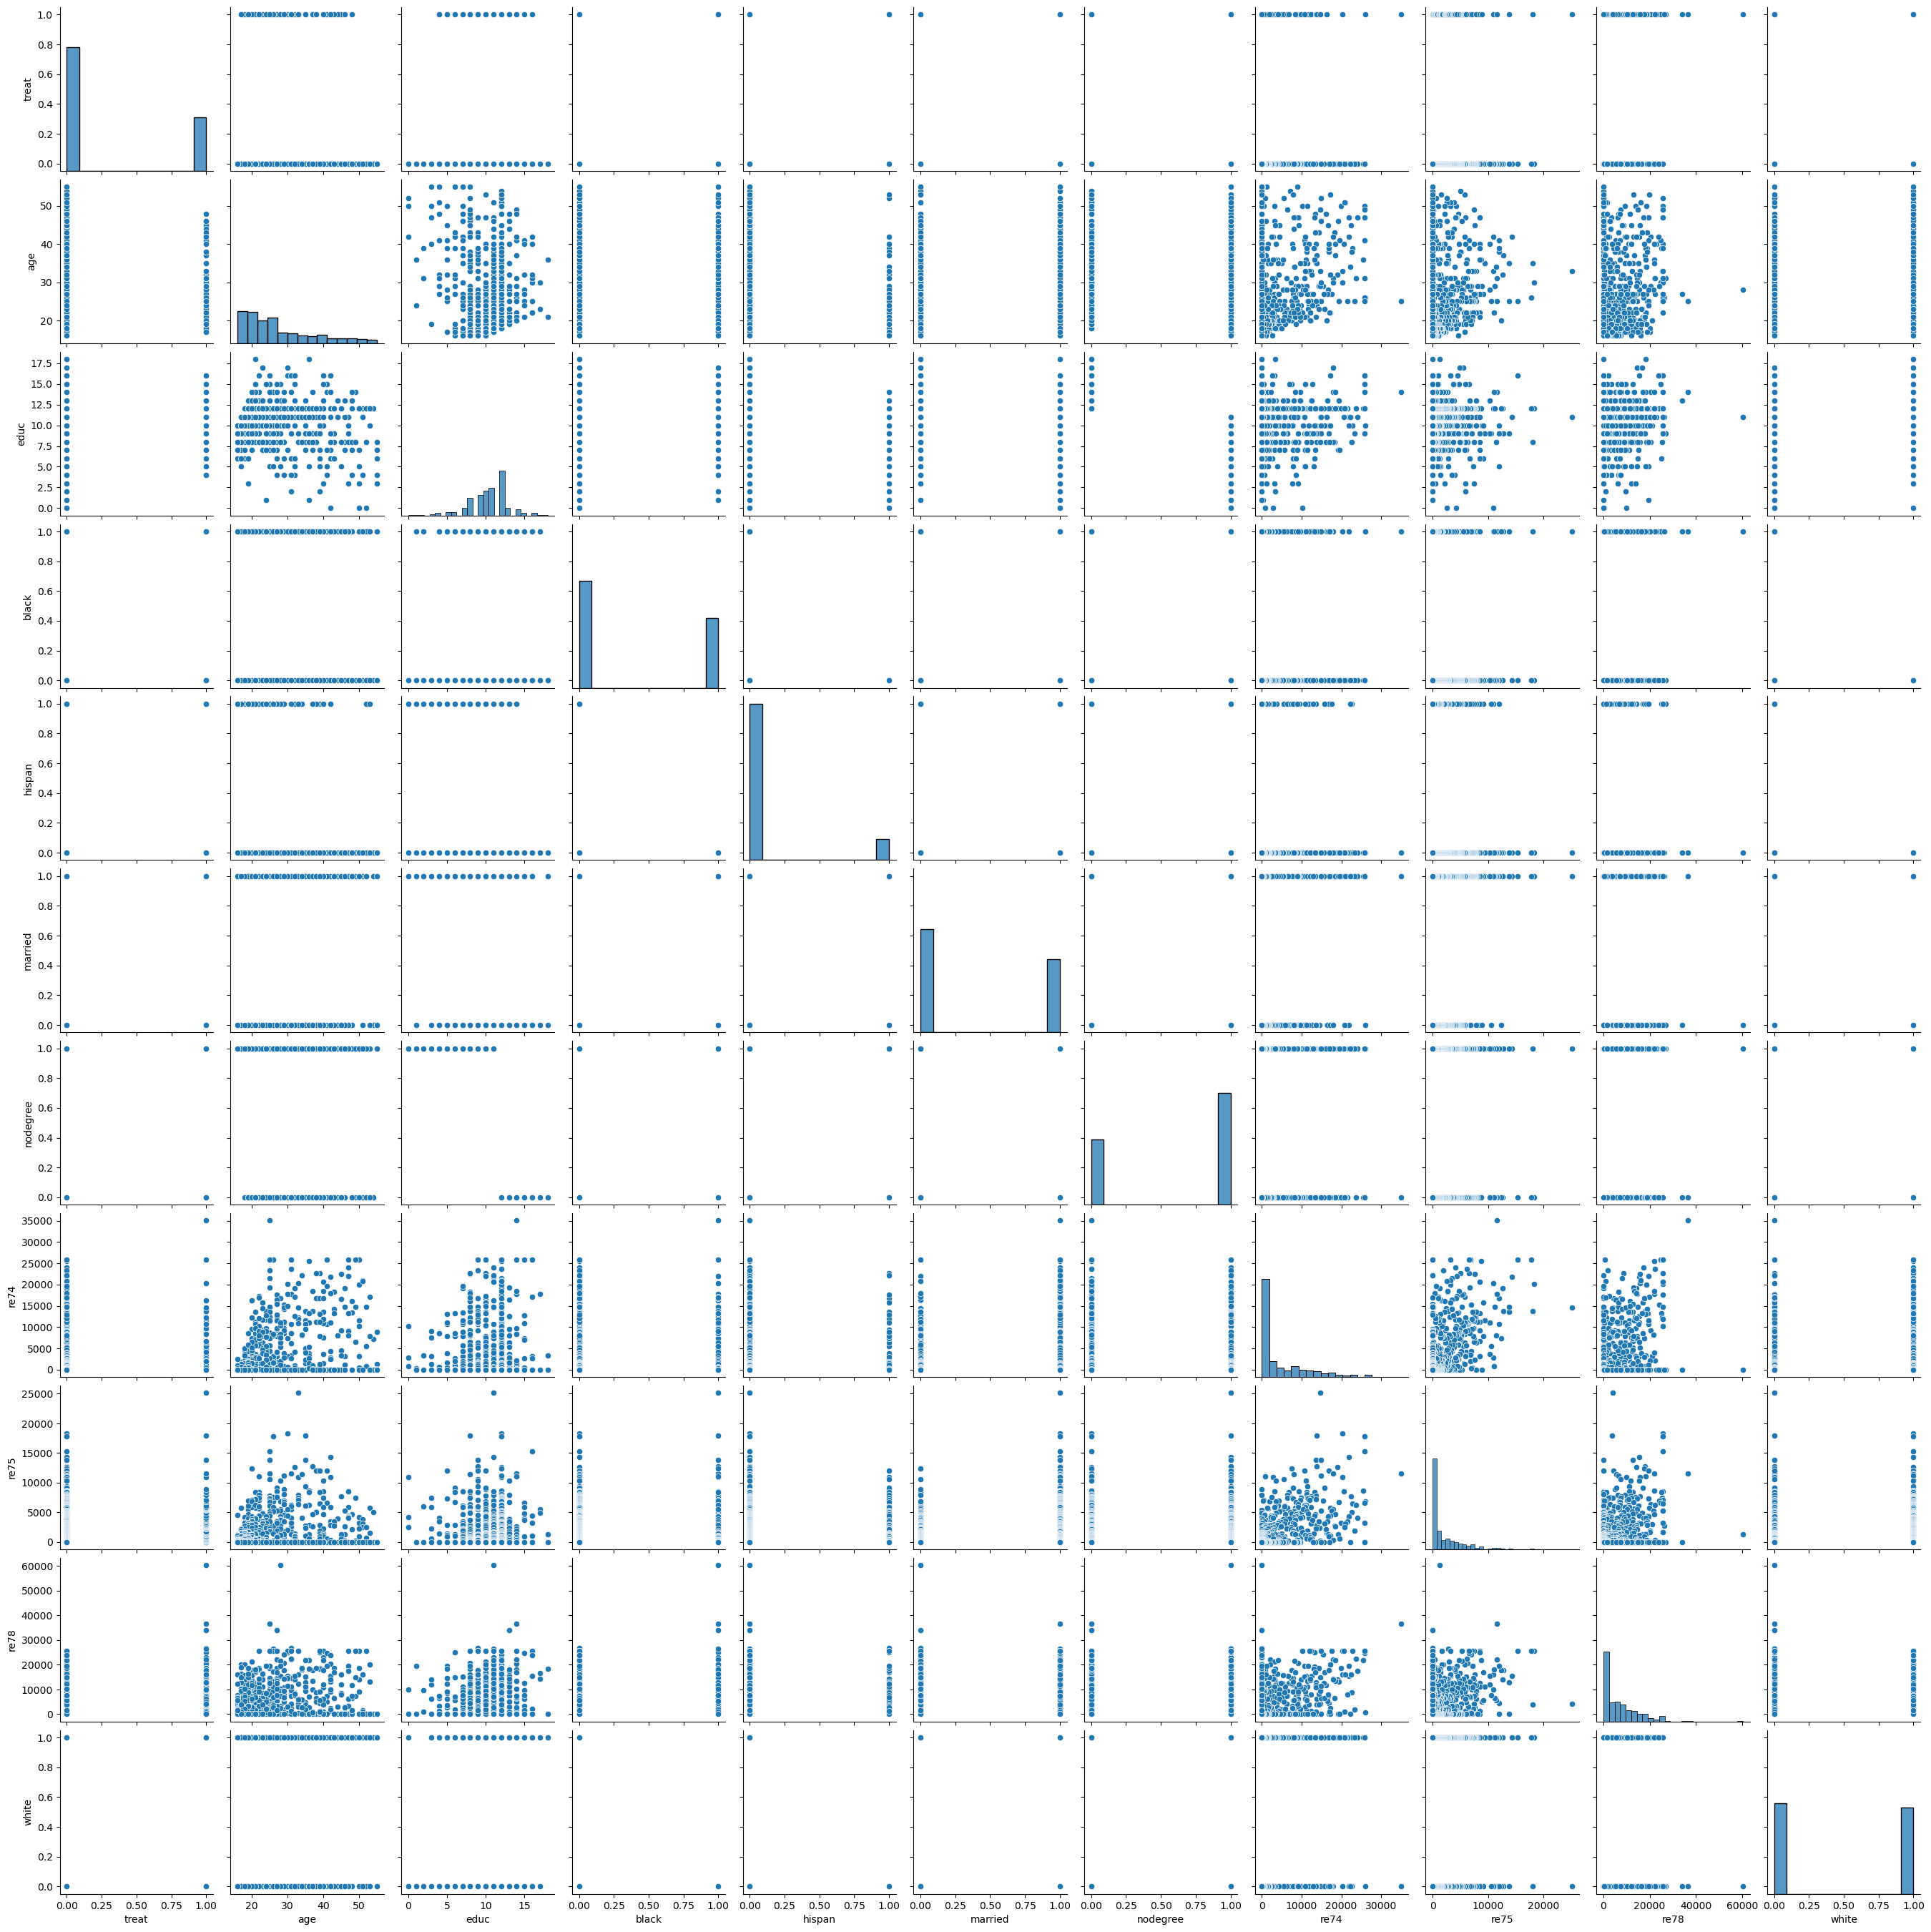

In [16]:
sns.pairplot(df)
plt.show()

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [17]:
''' your code and explanations '''
#standardization des features continues. 
# x_stand = (x-mean)/std

df['age'] = (df['age'] - df['age'].mean())/df['age'].std()
df['educ'] = (df['educ'] - df['educ'].mean())/df['educ'].std()
df['re74'] = (df['re74'] - df['re74'].mean())/df['re74'].std()
df['re75'] = (df['re75'] - df['re75'].mean())/df['re75'].std()

#declares the model
mod = smf.logit(formula='treat ~  age + educ + C(black) + C(hispan) + C(married) + C(nodegree) +\
        +re74 + re75',data = df)
#NOTE : +\ permet de revenir à la ligne sans changer la synthaxe. 
# une ligne équivalente est : 
# mod = smf.logit(formula='treat ~  age + educ + C(black) + C(hispan) + C(married) + C(nodegree) +re74 + re75',data = df)

res = mod.fit()
df['propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:                  0.3508
Time:                        16:10:37   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

In [18]:
treated = df.loc[df.treat ==1]
control = df.loc[df.treat ==0]

In [19]:
treated.propensity_score.describe()

count    185.000000
mean       0.577436
std        0.220285
min        0.024952
25%        0.526464
50%        0.653684
75%        0.726600
max        0.853153
Name: propensity_score, dtype: float64

In [20]:
control.propensity_score.describe()

count    429.000000
mean       0.182225
std        0.229521
min        0.009080
25%        0.038881
50%        0.075849
75%        0.195136
max        0.789173
Name: propensity_score, dtype: float64

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [21]:
''' your code and explanations ''';
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [22]:
treated_df = df.loc[df.treat ==1]
control_df = df.loc[df.treat ==0]

G = nx.Graph()

for control_id, control_row in control_df.iterrows():
    for treated_id, treated_row in treated_df.iterrows():
        
        similarity = get_similarity(control_row['propensity_score'], treated_row['propensity_score'])
        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treated_id, similarity)])


# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [23]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_df = df.iloc[matched]

In [24]:
balance_treated_df = balanced_df.loc[balanced_df.treat ==1]
balance_control_df = balanced_df.loc[balanced_df.treat ==0]

In [25]:
balance_treated_df.re78.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [26]:
balance_control_df.re78.describe()

count      185.000000
mean      5454.776050
std       6063.836916
min          0.000000
25%          0.000000
50%       3358.873000
75%       7933.914000
max      23764.800000
Name: re78, dtype: float64

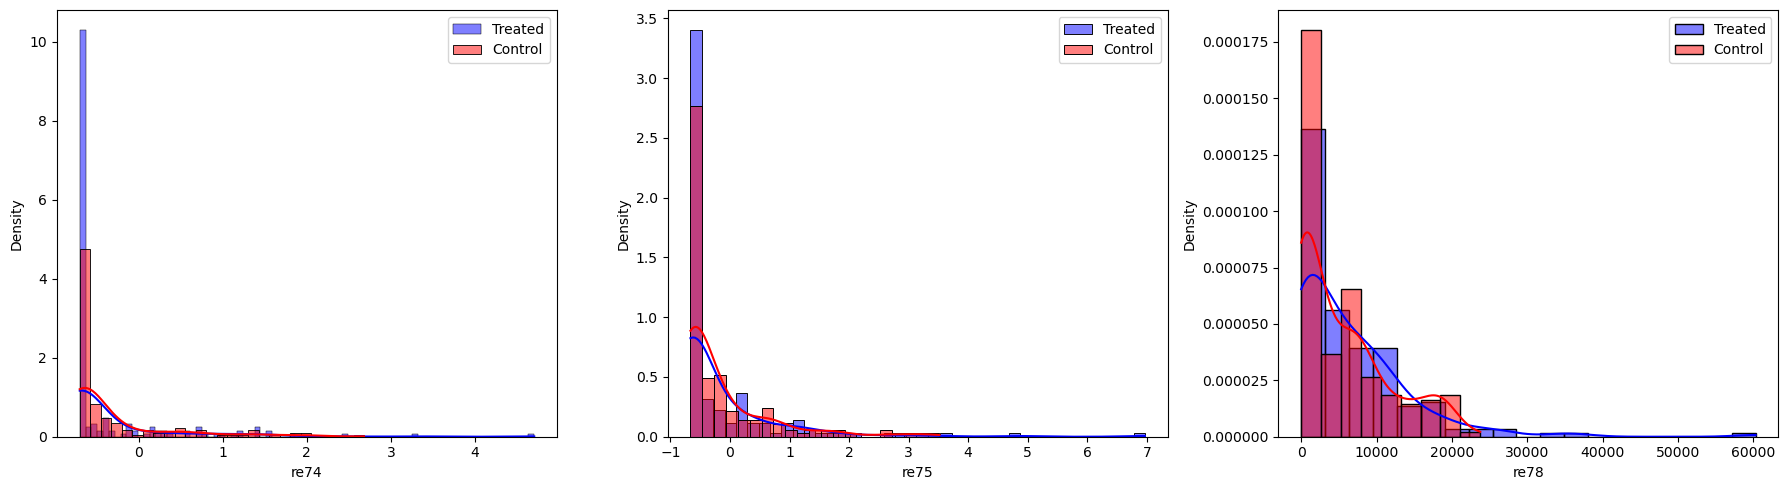

In [27]:
''' your code and explanations '''

fig, (ax1, ax2, ax3)= plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(balance_treated_df.re74, color ='blue', label = 'Treated', stat = 'density', kde = True, alpha = 0.5, ax = ax1)
sns.histplot(balance_control_df.re74, color = 'red', label = 'Control', stat = 'density', kde = True, alpha = 0.5, ax = ax1)
ax1.set_xlabel('re74')
ax1.set_ylabel('Density')
ax1.legend()

sns.histplot(balance_treated_df.re75, color ='blue', label = 'Treated', stat = 'density', kde = True, alpha = 0.5, ax = ax2)
sns.histplot(balance_control_df.re75, color = 'red', label = 'Control', stat = 'density', kde = True, alpha = 0.5, ax = ax2)
ax2.set_xlabel('re75')
ax2.set_ylabel('Density')
ax2.legend()

sns.histplot(balance_treated_df.re78, color ='blue', label = 'Treated', stat = 'density', kde = True, alpha = 0.5, ax = ax3)
sns.histplot(balance_control_df.re78, color = 'red', label = 'Control', stat = 'density', kde = True, alpha = 0.5, ax = ax3)
ax3.set_xlabel('re78')
ax3.set_ylabel('Density')
ax3.legend()

plt.tight_layout()
plt.show()

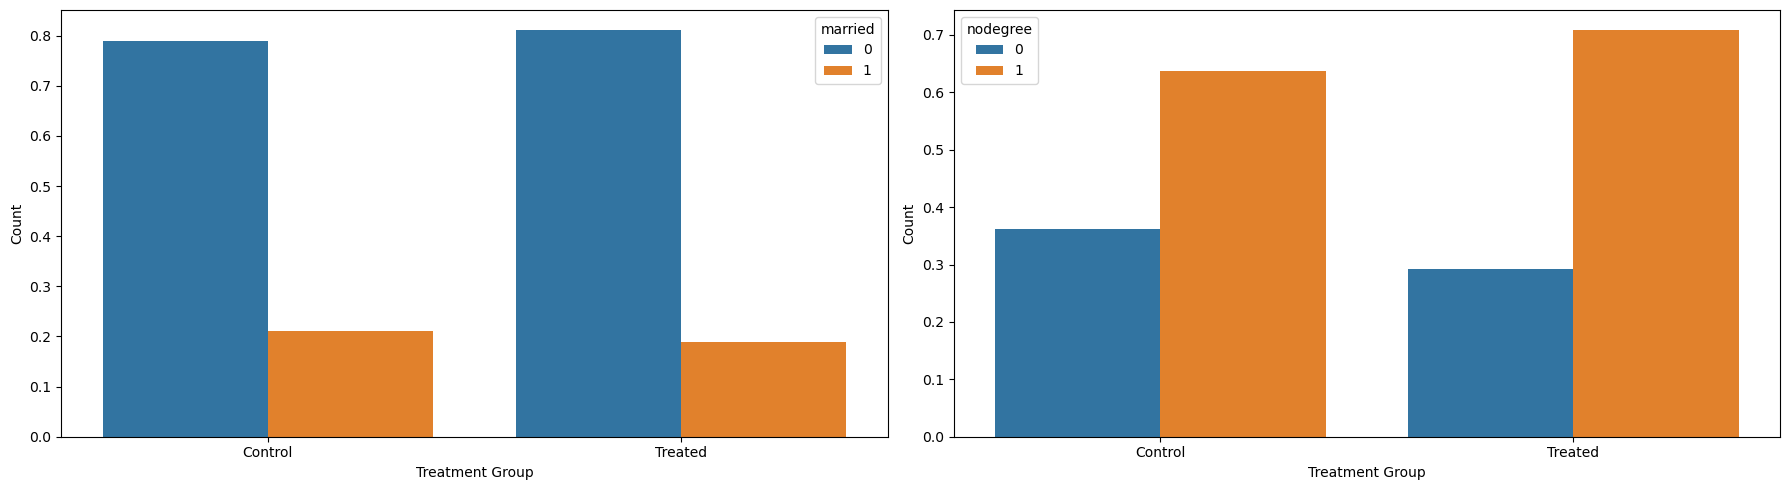

In [28]:
group_married = balanced_df.groupby(['treat', 'married'])['married'].count()
group_married = group_married.unstack()
group_married = group_married.div(group_married.sum(axis=1),axis=0) #permet de passer en pourcentage
group_married = group_married.reset_index().melt(id_vars='treat', var_name='married', value_name='count')

group_nodegree = balanced_df.groupby(['treat','nodegree'])['nodegree'].count()
group_nodegree = group_nodegree.unstack()
group_nodegree = group_nodegree.div(group_nodegree.sum(axis=1),axis=0) #permet de passer en pourcentage
group_nodegree = group_nodegree.reset_index().melt(id_vars='treat', var_name='nodegree', value_name='count')

#sns.barplot est chiant à utiliser, vaut mieux utiliser df.plot(kind = 'bar', ...)
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(data = group_married, x='treat', y = 'count', hue ='married', ax = axs[0])
axs[0].set_xticks([0, 1], ['Control', 'Treated'])
axs[0].set_xlabel('Treatment Group')
axs[0].set_ylabel('Count')

sns.barplot(data = group_nodegree, x='treat', y = 'count', hue ='nodegree', ax = axs[1])
axs[1].set_xticks([0, 1], ['Control', 'Treated'])
axs[1].set_xlabel('Treatment Group')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

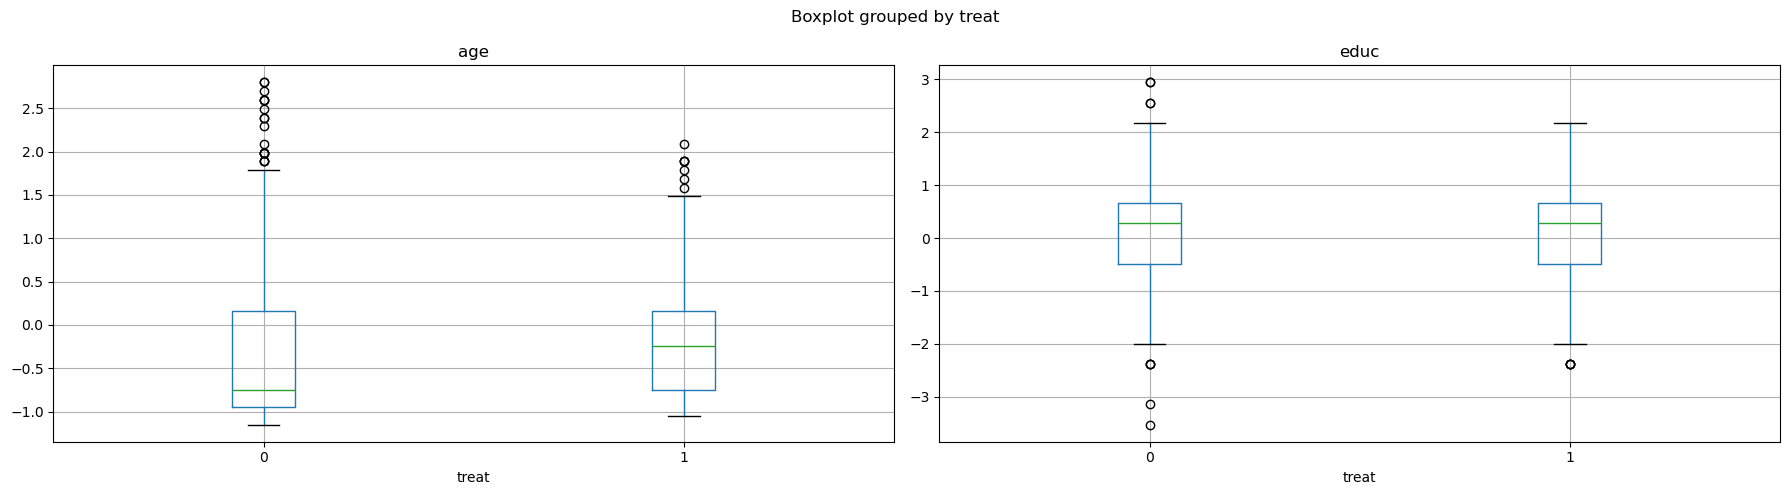

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

balanced_df.boxplot(by='treat', column ='age', grid=True, ax = axs[0])
balanced_df.boxplot(by='treat', column ='educ', grid=True, ax = axs[1])

plt.tight_layout()
plt.show()

C:\Users\bapti\AppData\Local\Temp\ipykernel_19228\1864778953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balanced_df['white'] = (~(balanced_df['black'].astype(bool)|balanced_df['hispan'].astype(bool))).astype(bool) #créer une colone pour les blancs


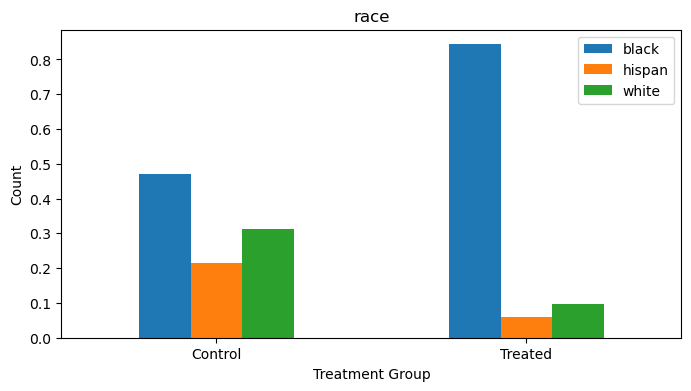

In [30]:
balanced_df['white'] = (~(balanced_df['black'].astype(bool)|balanced_df['hispan'].astype(bool))).astype(bool) #créer une colone pour les blancs

group_ethnic = balanced_df.groupby(df.treat)[['black','hispan','white']].sum()
group_ethnic = group_ethnic.div(group_ethnic.sum(axis=1), axis=0)

plot = group_ethnic.plot(kind='bar', figsize=[8,4], rot=0) #, stacked = True)
plot.set_title('race')
plot.set_ylabel('participants')
plot.set_xlabel('group')

plt.xticks([0, 1], ['Control', 'Treated'])
plt.xlabel('Treatment Group')
plt.ylabel('Count')
plt.show()

In [31]:
# le balance a rien changé au niveau de l'ethnie. Ni trop au niveau de l'âge.

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [32]:
''' your code and explanations '''

treated_df = df.loc[df.treat ==1]
control_df = df.loc[df.treat ==0]

G = nx.Graph()

for control_id, control_row in control_df.iterrows():
    for treated_id, treated_row in treated_df.iterrows():

         # Adds an edge only if the individuals have the same race
        if (control_row['black'] == treated_row['black']) and (control_row['hispan'] == treated_row['hispan']):
            # ajouter : and (control_row['age'] == treated_row['age']) dans les conditions si on veut balanced l'âge
            similarity = get_similarity(control_row['propensity_score'],
                                        treated_row['propensity_score'])

            G.add_weighted_edges_from([(control_id, treated_id, similarity)])

matching = nx.max_weight_matching(G)


In [33]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_df_all = df.iloc[matched]
print(len(balanced_df_all))

232


C:\Users\bapti\AppData\Local\Temp\ipykernel_19228\1801595064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balanced_df_all['white'] = (~(balanced_df_all['black'].astype(bool)|balanced_df_all['hispan'].astype(bool))).astype(bool) #créer une colone pour les blancs


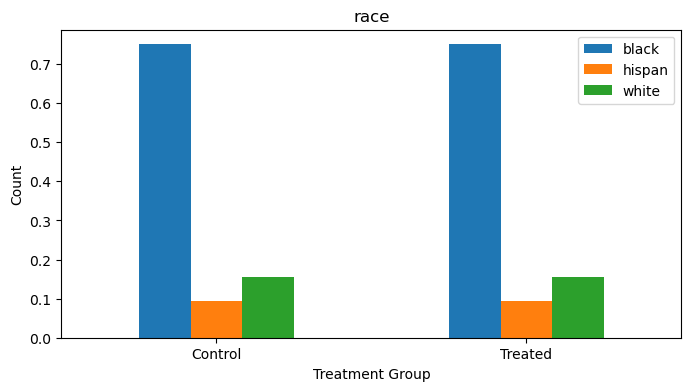

In [34]:
balanced_df_all['white'] = (~(balanced_df_all['black'].astype(bool)|balanced_df_all['hispan'].astype(bool))).astype(bool) #créer une colone pour les blancs

group_ethnic = balanced_df_all.groupby(df.treat)[['black','hispan','white']].sum()
group_ethnic = group_ethnic.div(group_ethnic.sum(axis=1), axis=0)

plot = group_ethnic.plot(kind='bar', figsize=[8,4], rot=0) #, stacked = True)
plot.set_title('race')
plot.set_ylabel('participants')
plot.set_xlabel('group')

plt.xticks([0, 1], ['Control', 'Treated'])
plt.xlabel('Treatment Group')
plt.ylabel('Count')
plt.show()

In [35]:
# c'est bien mieux pour l'ethnie maintenant.

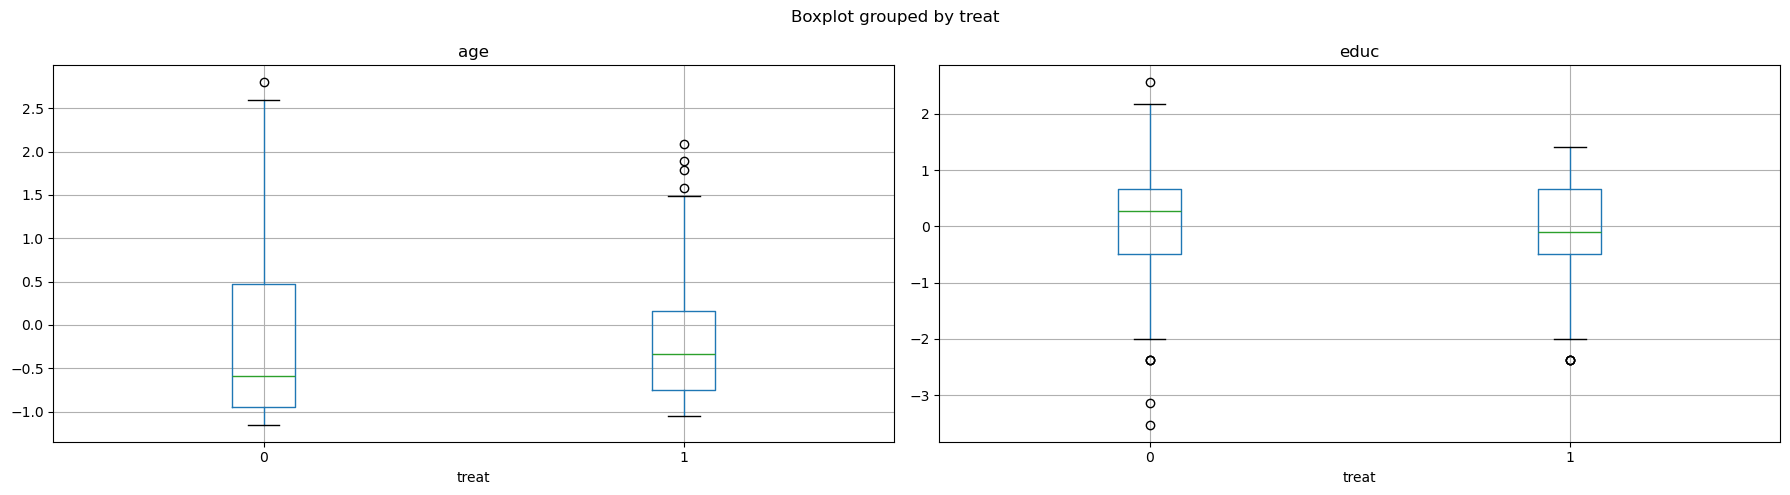

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

balanced_df_all.boxplot(by='treat', column ='age', grid=True, ax = axs[0])
balanced_df_all.boxplot(by='treat', column ='educ', grid=True, ax = axs[1])

plt.tight_layout()
plt.show()

In [37]:
#l'âge est toujours un peu problématique on peut ajouter une condition pour mieux faire la balance

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [38]:
''' your code and explanations ''';
treated_df = balanced_df_all.loc[balanced_df_all.treat ==1]
control_df = balanced_df_all.loc[balanced_df_all.treat ==0]


In [39]:
treated_df.re78.describe()

count      116.000000
mean      6375.738003
std       6670.986821
min          0.000000
25%        758.102600
50%       4648.736000
75%      10160.440000
max      36646.950000
Name: re78, dtype: float64

In [40]:
control_df.re78.describe()

count      116.000000
mean      5095.456025
std       6047.014862
min          0.000000
25%          0.000000
50%       2256.488500
75%       8942.092750
max      20243.380000
Name: re78, dtype: float64

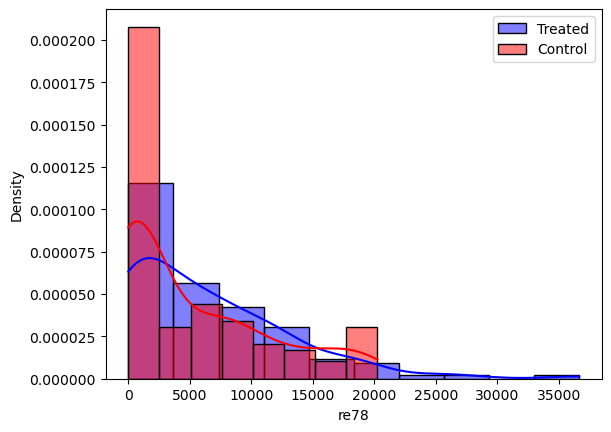

In [41]:
ax = sns.histplot(treated_df.re78, color ='blue', label = 'Treated', stat = 'density', kde = True, alpha = 0.5)
ax = sns.histplot(control_df.re78, color = 'red', label = 'Control', stat = 'density', kde = True, alpha = 0.5)
plt.legend()
plt.show()